 Step-by-step preprocess these datasets for consistency:
1. Resampling:
	• Decide on a common voxel size for all datasets. Pick 'Miriam' dataset.
	• Use a library SimpleITK to resample all datasets to this chosen voxel size.
2. Field of View Alignment:
	• Determine a common FOV. Set voxel (0,0,0) to the same physical space ([-181, -181, -229])
3. Cropping a dataset to focus on a specific region of interest (ROI). 
	We are interested in the beam center and want to reduce computational complexity.
	==> 8 voxels in lateral position from the source position.
	==> 128 voxel along the beam through the head.
	Shape 16x16x128
	
4. Normalization:
	• Normalize intensity values  with minmax scaling across all datasets to ensure a similar range[0,1].
5. Combining & Shuffling:
	• Combine all 5 preprocessed datasets.
	• Shuffle combined data so that during training, models aren't biased by seeing long sequences from one specific dataset.
6. Data Splitting:
	• split the data into training, validation, and test sets.80%-10%-10% split.


In [1]:
pip install SimpleITK

Note: you may need to restart the kernel to use updated packages.


In [2]:
# xzy
datasets = {
    "Miriam": {
        "voxel_dim": [0.707031*2, 0.707031*2, 1.25*2],
        "origin": [-181, -181, -229],
        "positions_x": [-110],
        "positions_y": [-50, -25, 0, 25, 50, 75],
        "positions_z": [-146.5, -121.5, -96.5, -71.5, -46.5],
        "voxel_center": [0,0,-71.5]
    },
    "Ali": {
        "voxel_dim": [0.759766*2, 0.759766*2, 1.25*2],
        "origin": [-194.5, -194.5, -271],
        "positions_x": [-110],
        "positions_y": [-25, 0, 25, 50, 75],
        "positions_z": [-171.5, -146.5, -121.5, -96.5, -71.5],
        "voxel_center": [0,0,-72.25]
    },
    "Pichaya": {
        "voxel_dim": [0.666016*2, 0.666016*2, 1.25*2],
        "origin": [-170.5,-170.5, -188.75],
        "positions_x": [-110],
        "positions_y": [-50, -25, 0, 25, 50, 75],
        "positions_z": [-71.5, -46.5, -21.5, 3.5],
        "voxel_center": [0,0,-32.5]
    },
    "Leo": {
        "voxel_dim": [0.689453*2, 0.689453*2, 1.25*2],
        "origin": [-176.5, -176.5, -208.25],
        "positions_x": [-110],
        "positions_y": [-50, -25, 0, 25, 50, 75],
        "positions_z": [-96.5, -71.5, -46.5, -21.5],
        "voxel_center": [0,0,-44.5]
    },
    "Hans": {
        "voxel_dim": [0.683594*2, 0.683594*2, 1.25*2],
        "origin": [-175, -175, -199.25],
        "positions_x": [-110],
        "positions_y": [-25, 0, 25, 50, 75],
        "positions_z": [-96.5, -71.5, -46.5, -21.5],
        "voxel_center": [0,0,-29.25]
    }
}

Resampling and FOV adjustments. This ensures that all images are on the same scale and cover the same anatomical regions.

In [3]:
import SimpleITK as sitk
import os
import numpy as np
import SimpleITK as sitk
import numpy as np

def set_sitk_image(array, dataset):
    # Convert numpy array to SimpleITK image
    sitk_image = sitk.GetImageFromArray(array)  

    # Set the spacing for Ali's data

    spacing = datasets[dataset]["voxel_dim"]
    sitk_image.SetSpacing(spacing) #xyz
    origin = datasets[dataset]["origin"]
    sitk_image.SetOrigin(origin)
    print(sitk_image.GetSpacing(),sitk_image.GetOrigin() )

    return sitk_image

    
def resample_image(input_image, new_spacing, new_origin):
    size = input_image.GetSize()
    print('size input_image ' ,size)
    spacing = input_image.GetSpacing()
    print(' spacing of input ',spacing)
    print(' new spacing ',new_spacing)
    new_size = [int(size[d] * spacing[d] / new_spacing[d]) for d in range(3)]
    print('new_size' ,new_size)
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetOutputOrigin(new_origin)
    resampler.SetOutputDirection(input_image.GetDirection())
    resampler.SetInterpolator(sitk.sitkLinear)
    
    resampled_image = resampler.Execute(input_image)
    return resampled_image


In [4]:
import SimpleITK as sitk
import numpy as np

def extract_from_filename(filename, param):
    """Extracts energy value from the given filename."""
    parts = filename.split('_')
    if param == 'y':
        return float(parts[2][:-2])
    if param == 'z':
        return float(parts[3][:-6])
    if param == 'energy':
        return parts[1]
    else:
        return None

# create function to extract ROI and convert to numpy
def extract_roi_array(image, roi_size, source_physical):
    source_index = image.TransformPhysicalPointToIndex(source_physical)
    print('source index y,z',source_index[1], source_index[2] )
    start_index = [int(source_index[0]-roi_size[0]*0.5), int(source_index[1]-roi_size[1]*0.5), int(source_index[2]-roi_size[2]*0.5)]
    print('start_index' , start_index)
    roi = sitk.RegionOfInterest(image, roi_size, start_index)
    return sitk.GetArrayFromImage(roi) 



In [ ]:
# Center of physical space of ROI
# X index = 124 will extract roi index from 60 to 188 (size = 128)
source_index = ali_resampled.TransformPhysicalPointToIndex([-5,0,-146.5])
source_index

(124, 128, 33)

In [6]:
    
# Example Usage:
data_folder = "/scratch/tappay01/data/data2"
filename ='Data2_1500MeV_0Mm_-146.5Mm.npy'
filepath = os.path.join(data_folder, filename)

# Load Ali's data from .npy
ali_array = np.load(filepath)
ali_image = set_sitk_image(ali_array, "Ali")
target_spacing = datasets["Miriam"]["voxel_dim"]
target_origin = datasets["Miriam"]["origin"]
print('target_origin ',target_origin )
# Resample the image
ali_resampled = resample_image(ali_image, target_spacing, target_origin)

(1.519532, 1.519532, 2.5) (-194.5, -194.5, -271.0)
target_origin  [-181, -181, -229]
size input_image  (256, 256, 159)
 spacing of input  (1.519532, 1.519532, 2.5)
 new spacing  [1.414062, 1.414062, 2.5]
new_size [275, 275, 159]


Verify that the maximum dose of the resampled data are at the same location with the source position in y and z.

In [7]:
'''should not require shift
# Calculate the shift required to match the FOV of "Miriam"
#option1:  align the top-left-front corner (origin) 
#shift = [p - a for p, a in zip(datasets["Miriam"]["origin"], datasets["Ali"]["origin"])]
#option2: match the centers of the two datasets
#shift = [0,0,0.75]#ensures that the "centers" of the two datasets align.
shift = [0,0,0]
print('shift ',shift)
# Adjust the FOV of the resampled "Ali" image
ali_resampled_adjusted = adjust_fov(ali_resampled, shift)
'''
array = sitk.GetArrayFromImage(ali_resampled)
max_index = np.unravel_index(array.argmax(), array.shape)

print('max_index x, y,z ',max_index[2], max_index[1], max_index[0] )

source_physical = [-5, extract_from_filename(filename,'y'), extract_from_filename(filename,'z')] 
# source at x postion = -110, but use -5 to crop from this point as center.

max_index x, y,z  160 128 32


In [8]:

# Extract ROI

roi_size = (128,16,16) #xyz  
roi_array = extract_roi_array(ali_resampled, roi_size, source_physical)

#np.save("roi_output.npy", roi_array)
roi_array.shape


source index y,z 128 33
start_index [60, 120, 25]


(16, 16, 128)

In [ ]:
# Get full array of size of Dataset1
full_size = (256,256,126) #xyz  
roi_array_full = extract_roi_array(ali_resampled, full_size, datasets["Miriam"]["voxel_center"])

#np.save("roi_output.npy", roi_array)
roi_array_full.shape


source index y,z 128 63
start_index [0, 0, 0]


(126, 256, 256)

Visualize the cropped array of size 16*16*128. 

-Plot in Miriam dataset's physical space

-Plot the intensity . We can see the highest dose at the ROI center (along the beam center) = voxel number 7

In [11]:
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
def plot_roi(roi_array):

    # Define center of the volume
    center =  int(roi_array.shape[0]/2)

    data_sample = roi_array
    print('Y direction')
    for i in range(16):
        print('voxel number ',i)
        #density_sample = density_batch[i, 0]
        #data_name_sample = data_name_batch[i]
        # Define the figure and the grid
        fig = plt.figure(figsize=(15, 3))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 0.2])  # 3 plots + 1 colorbar
        max_index = np.unravel_index(data_sample.argmax(), data_sample.shape)
            
        # ZY plane
        ax0 = plt.subplot(gs[0])
        #ax0.imshow(density_sample[:, :, max_index[2]], cmap='gray')
        ax0.imshow(data_sample[:, :,max_index[2]], cmap='inferno', alpha=0.7)
        ax0.set_title("ZY Plane")
        ax0.set_xlabel('Z voxel number')
        ax0.set_ylabel('Y voxel number')

        # ZX plane
        ax1 = plt.subplot(gs[1])
        #ax1.imshow(density_sample[:, center[1], :], cmap='gray')
        img_data = ax1.imshow(data_sample[:, i, :], cmap='inferno', alpha=0.7)
        ax1.set_xlabel('X voxel number')
        ax1.set_ylabel('Z voxel number')

        # Colorbar
        cax = plt.subplot(gs[2])
        cbar = plt.colorbar(img_data, cax=cax)
        cbar.set_label('dose [Gy]')

        plt.tight_layout()
        plt.show()

    print('Z direction')
    for i in range(16):
        print('voxel number ',i)
        #density_sample = density_batch[i, 0]
        #data_name_sample = data_name_batch[i]
        # Define the figure and the grid
        fig = plt.figure(figsize=(15, 3))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 0.2])  # 3 plots + 1 colorbar
        max_index = np.unravel_index(data_sample.argmax(), data_sample.shape)
            
        # ZY plane
        ax0 = plt.subplot(gs[0])
        #ax0.imshow(density_sample[:, :, max_index[2]], cmap='gray')
        ax0.imshow(data_sample[:, :,max_index[2]], cmap='inferno', alpha=0.7)
        ax0.set_title("ZY Plane")
        ax0.set_xlabel('Z voxel number')
        ax0.set_ylabel('Y voxel number')

        # YX plane
        ax2 = plt.subplot(gs[1])
        #ax2.imshow(density_sample[center[0], :, :], cmap='gray')
        img_data = ax2.imshow(data_sample[i, :, :], cmap='inferno', alpha=0.7)
        ax2.set_xlabel('X voxel number')
        ax2.set_ylabel('Y voxel number')

        # Colorbar
        cax = plt.subplot(gs[2])
        cbar = plt.colorbar(img_data, cax=cax)
        cbar.set_label('dose [Gy]')

        plt.tight_layout()
        plt.show()

Y direction
voxel number  0


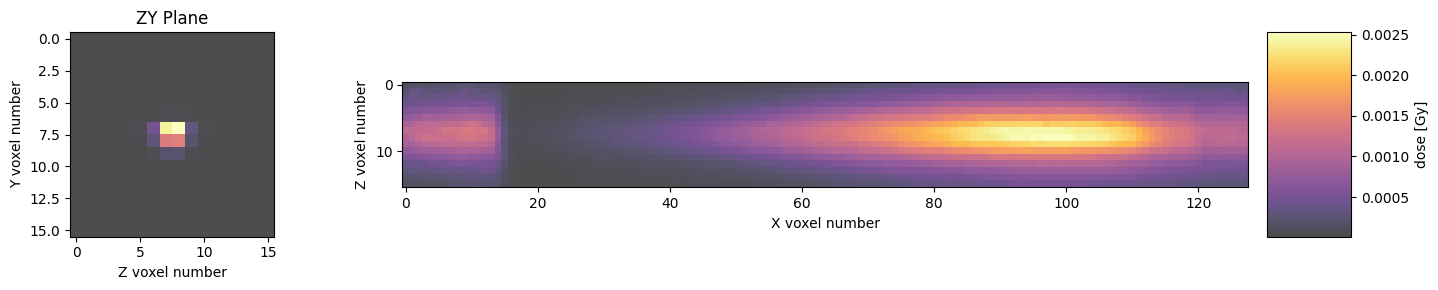

voxel number  1


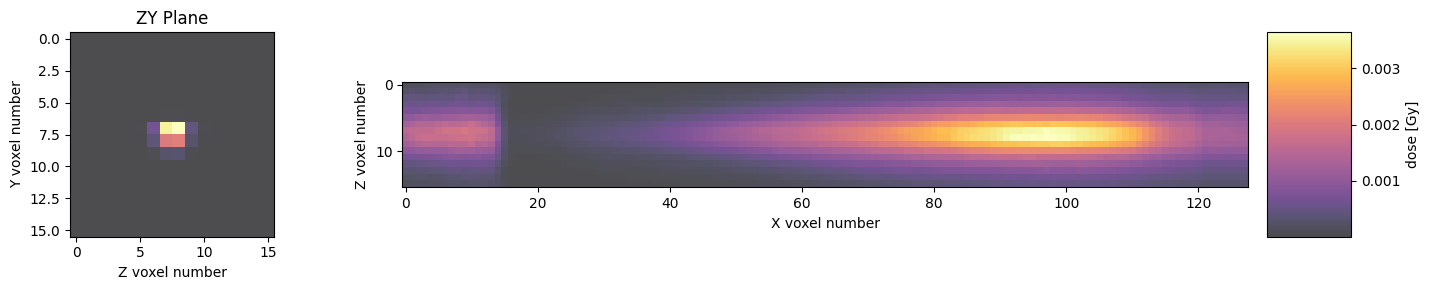

voxel number  2


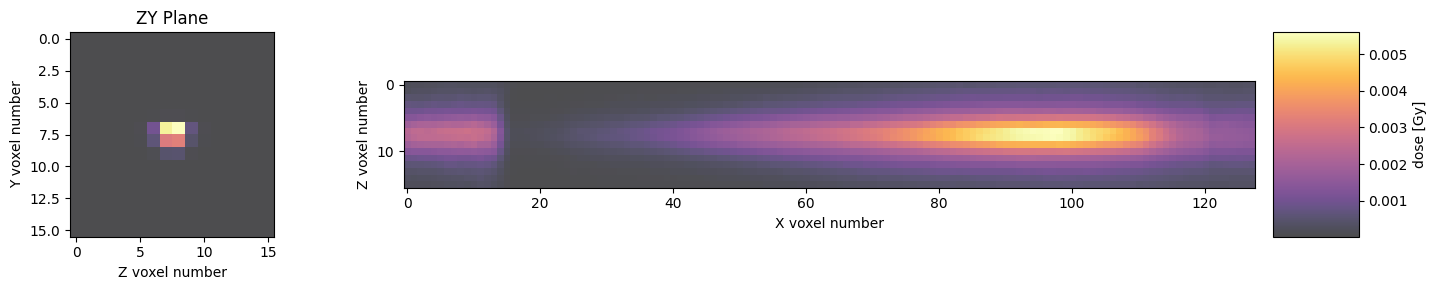

voxel number  3


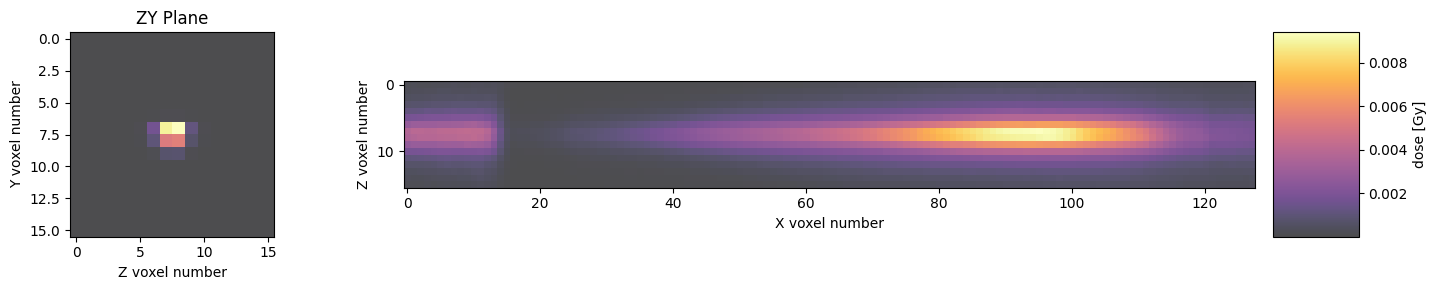

voxel number  4


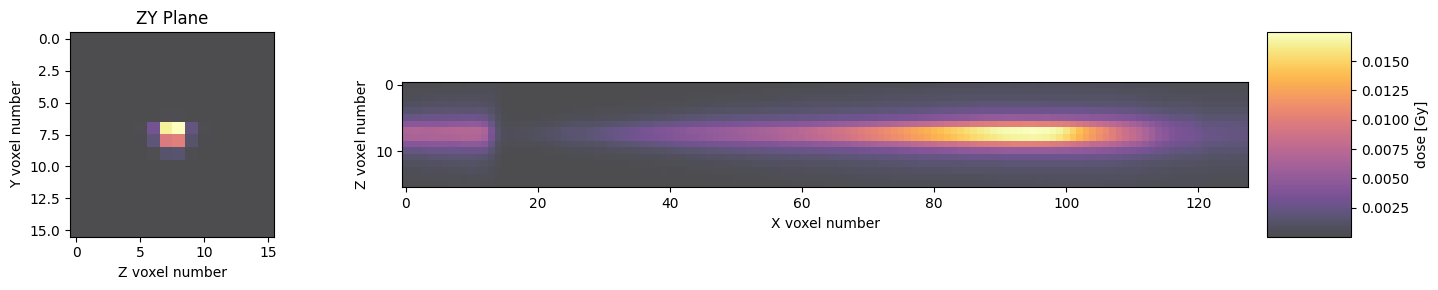

voxel number  5


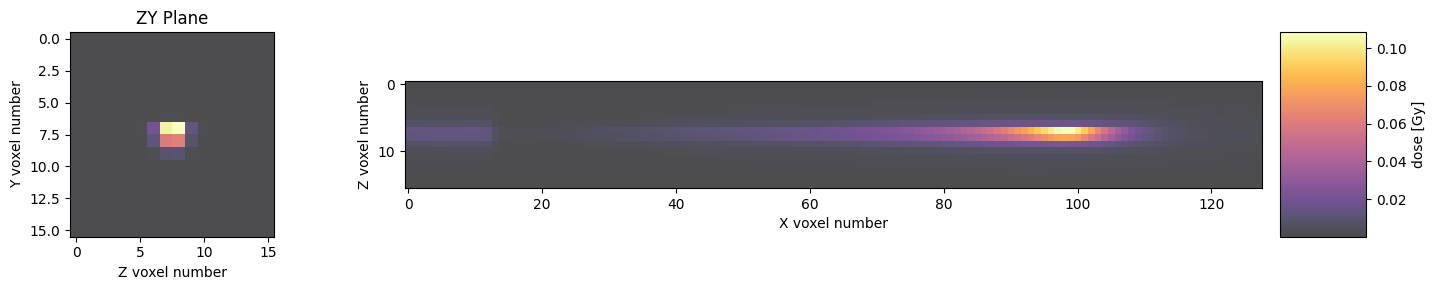

voxel number  6


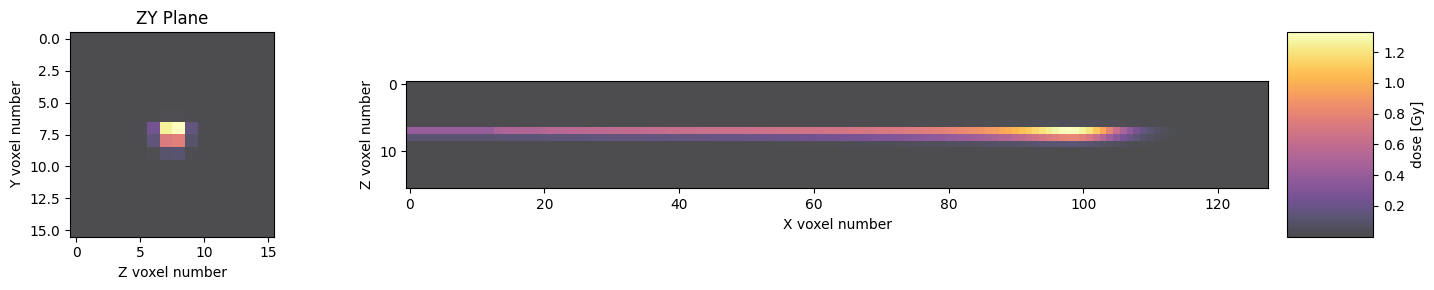

voxel number  7


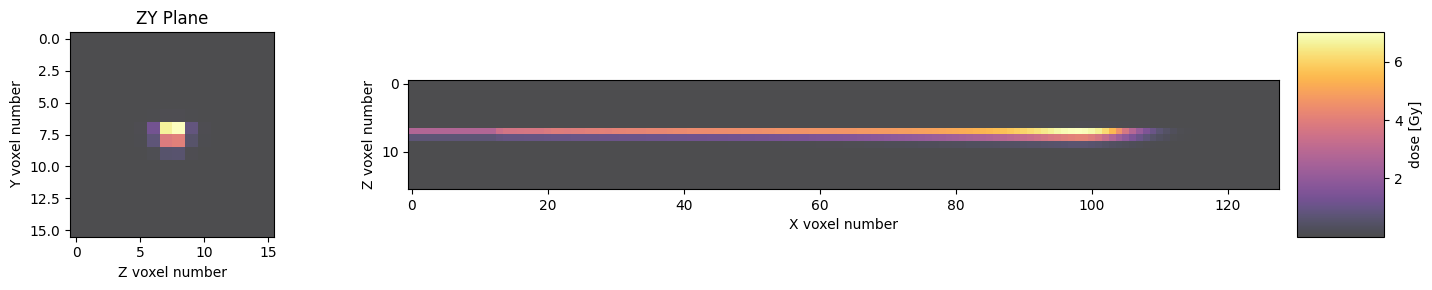

voxel number  8


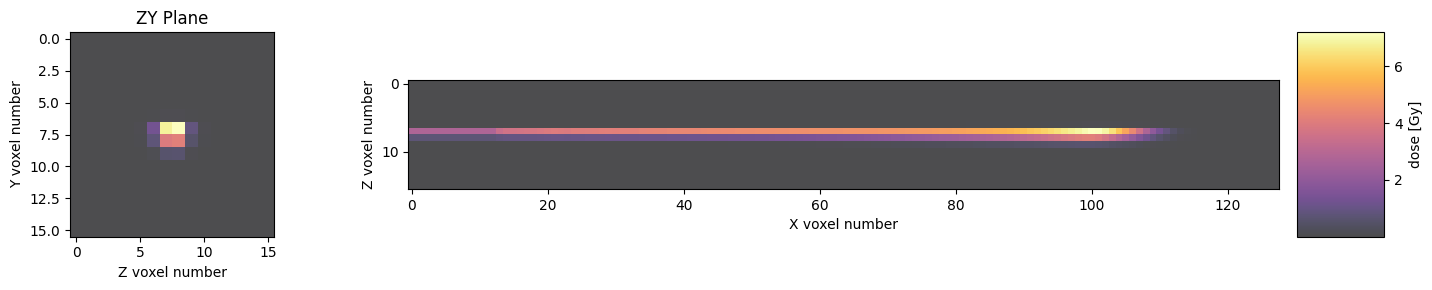

voxel number  9


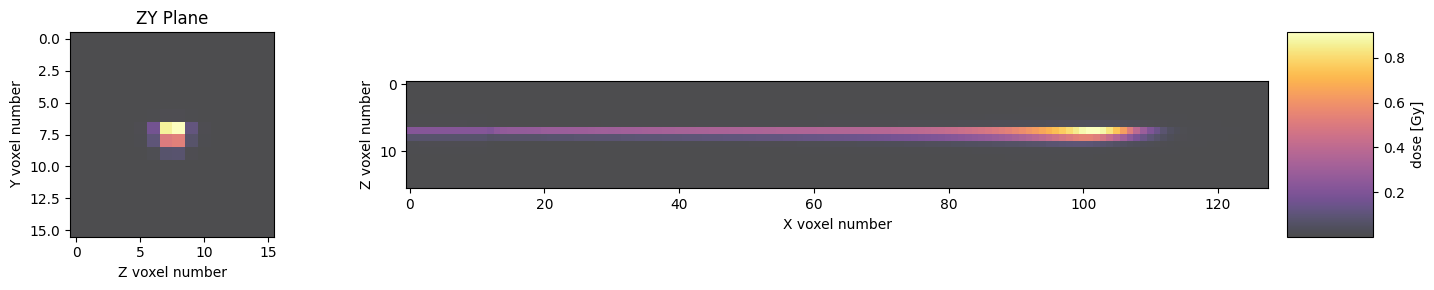

voxel number  10


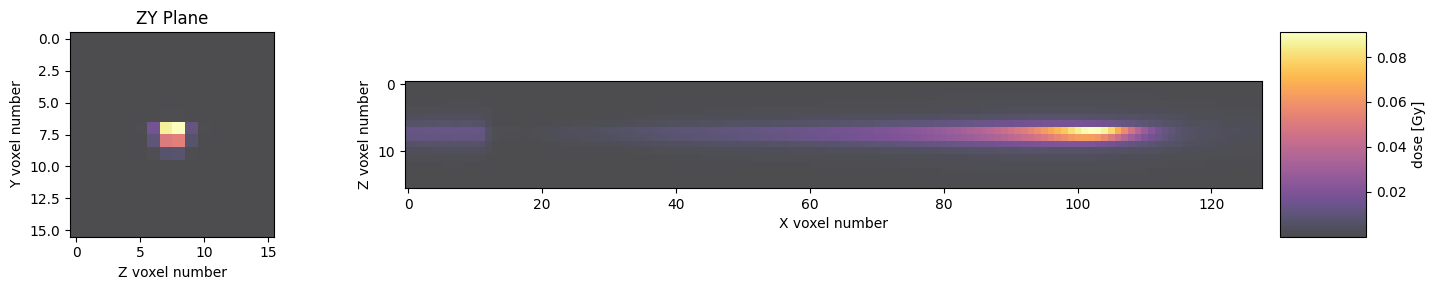

voxel number  11


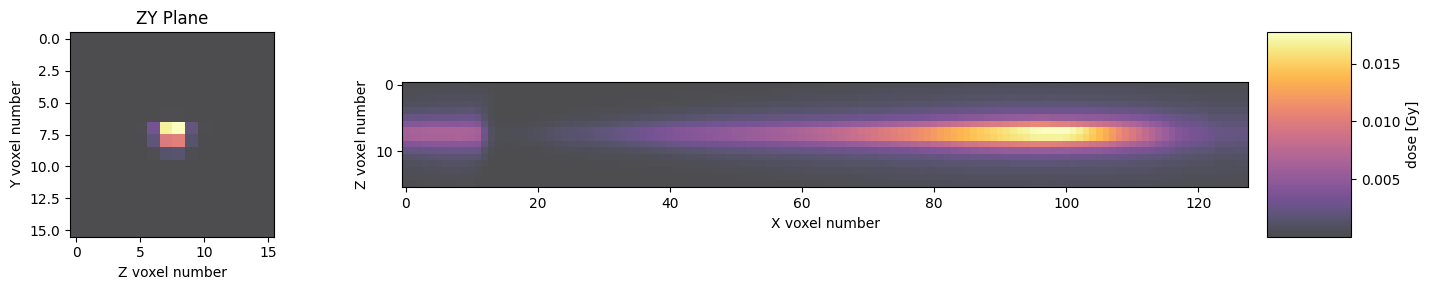

voxel number  12


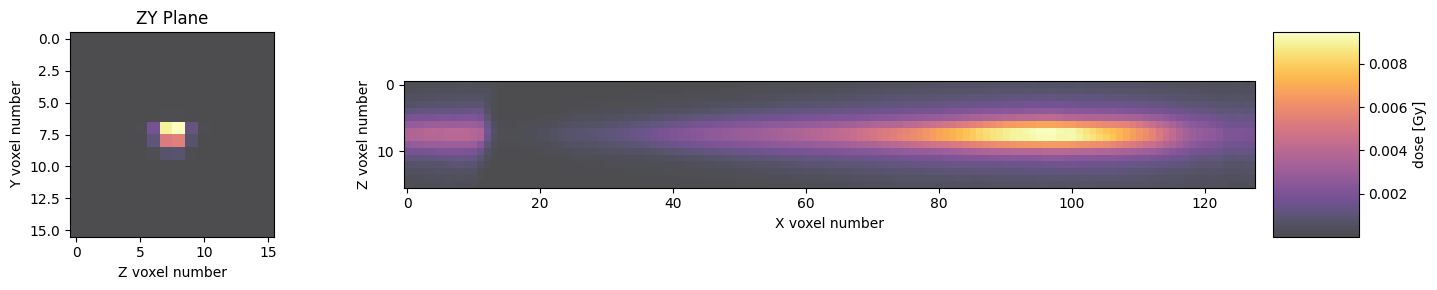

voxel number  13


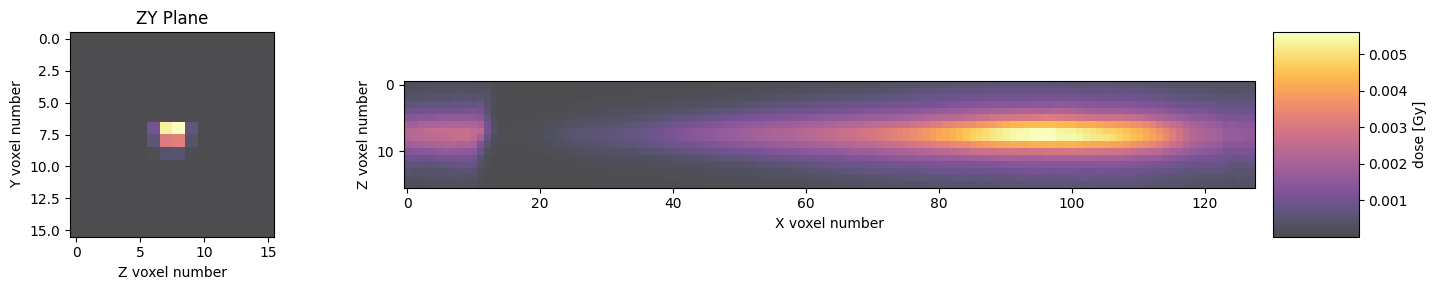

voxel number  14


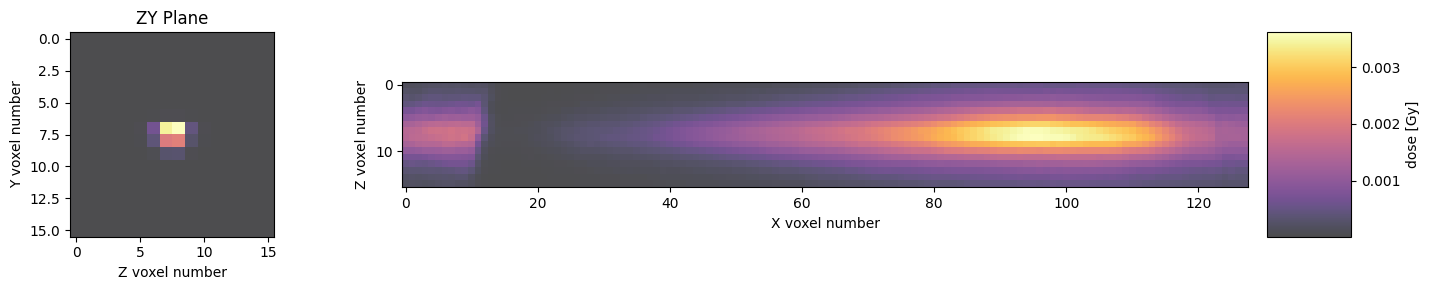

voxel number  15


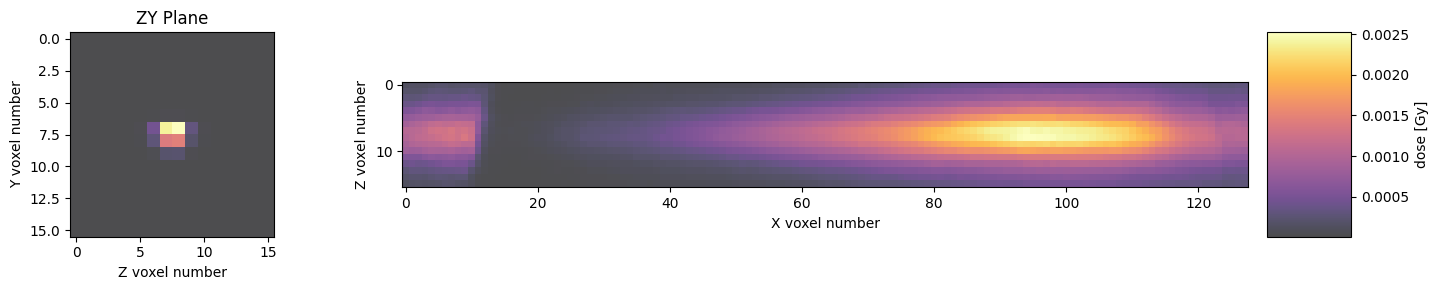

Z direction
voxel number  0


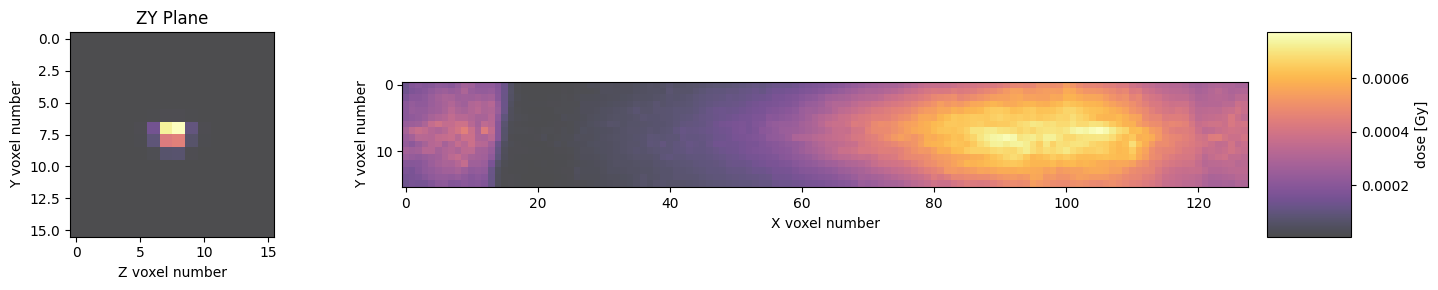

voxel number  1


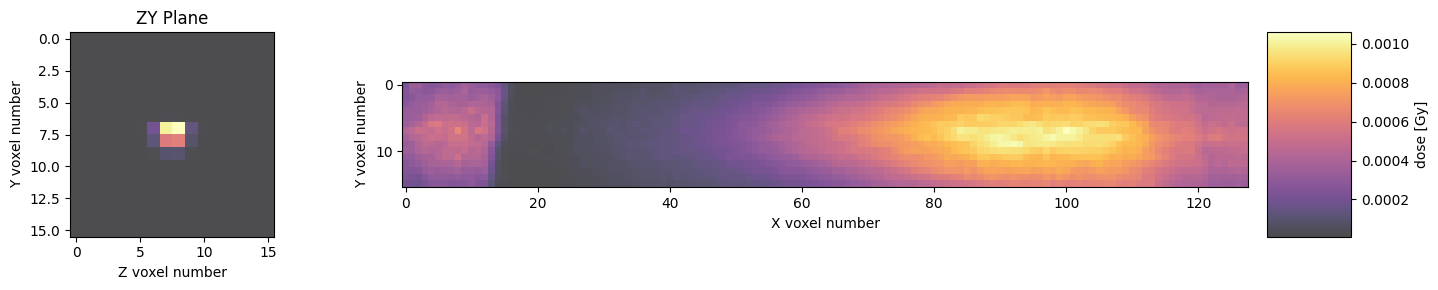

voxel number  2


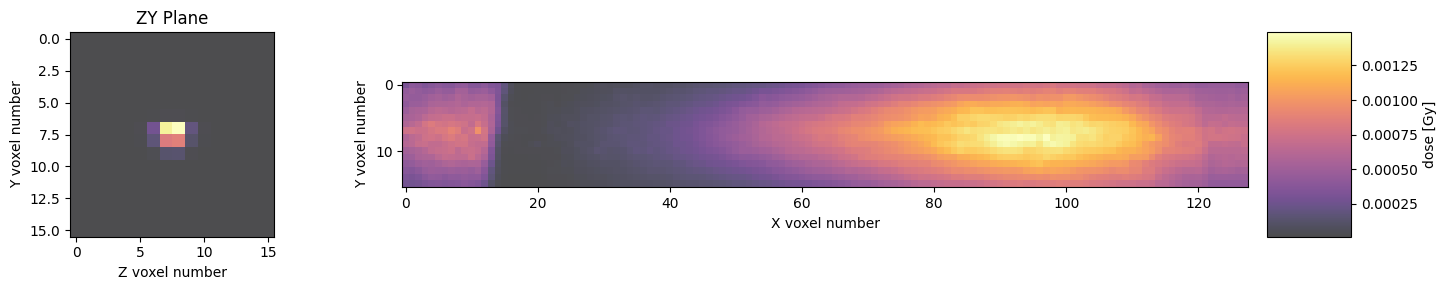

voxel number  3


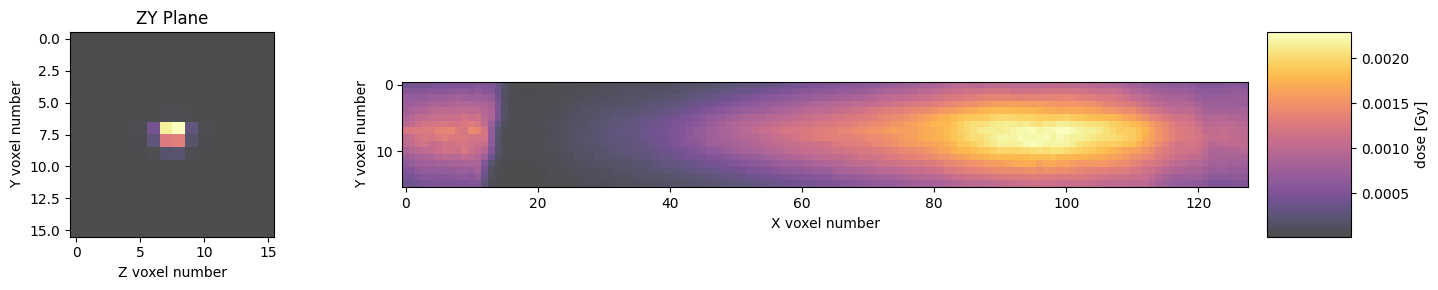

voxel number  4


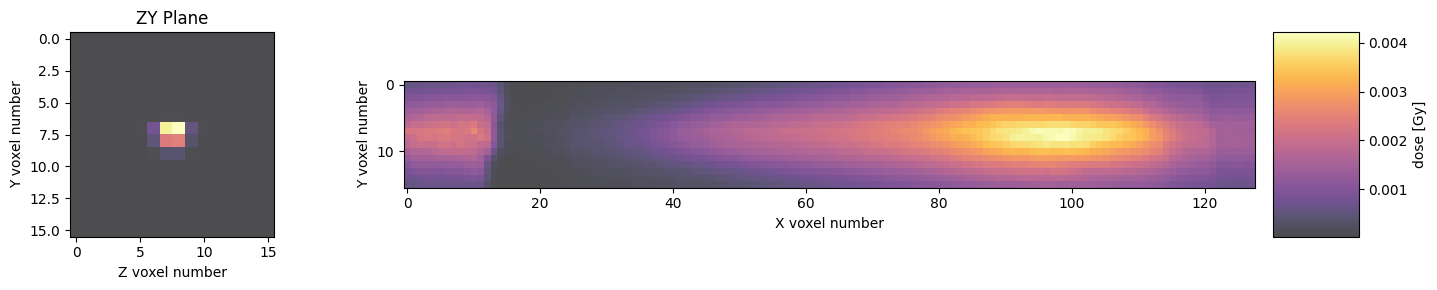

voxel number  5


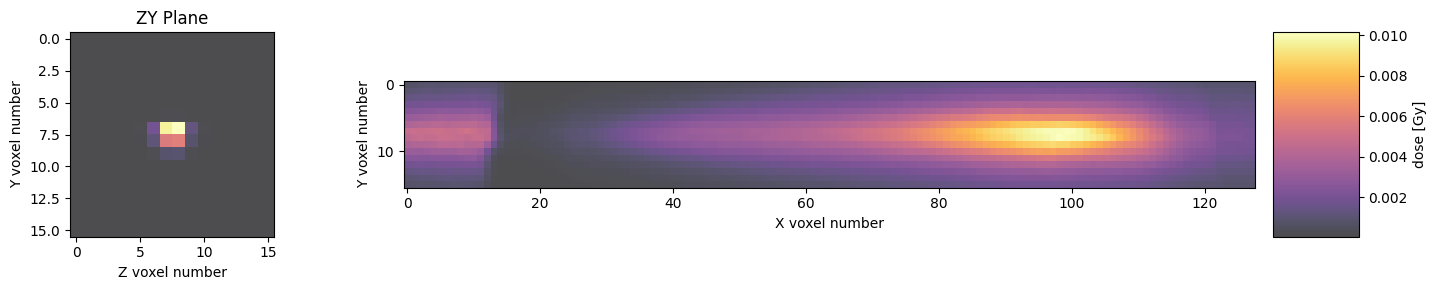

voxel number  6


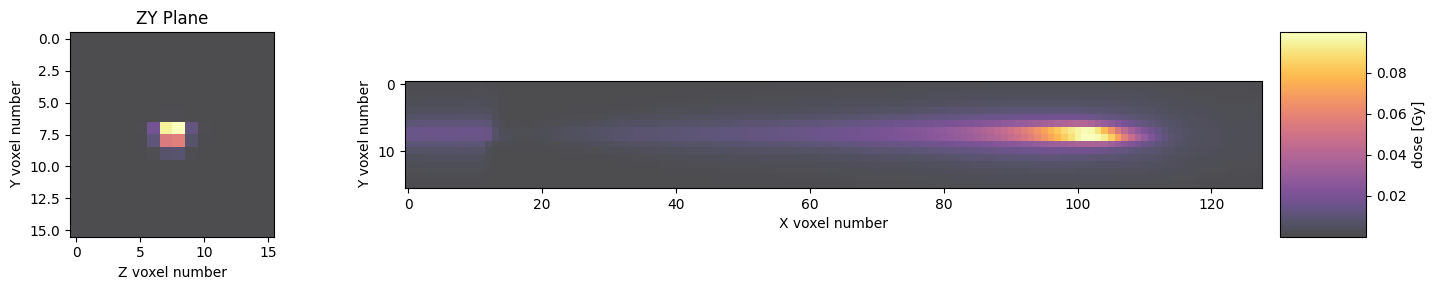

voxel number  7


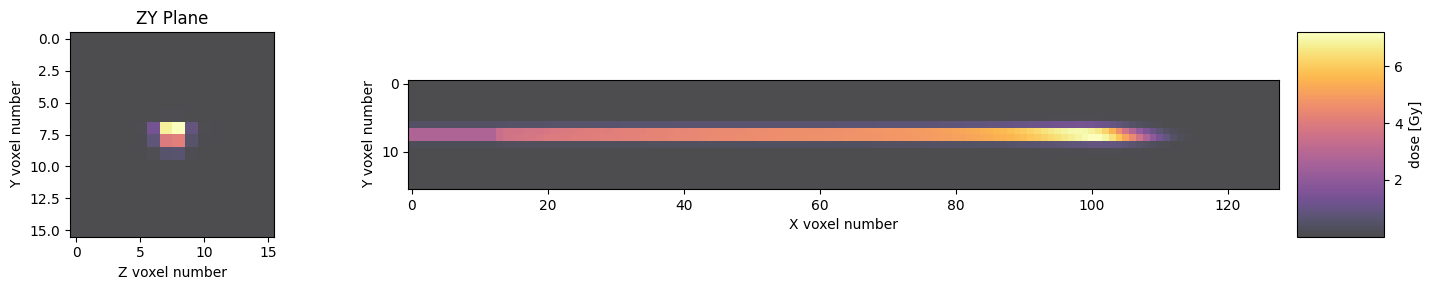

voxel number  8


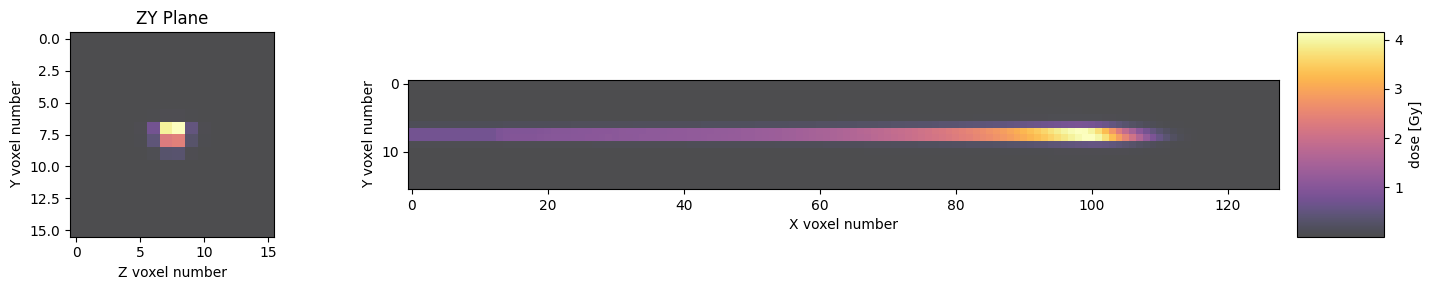

voxel number  9


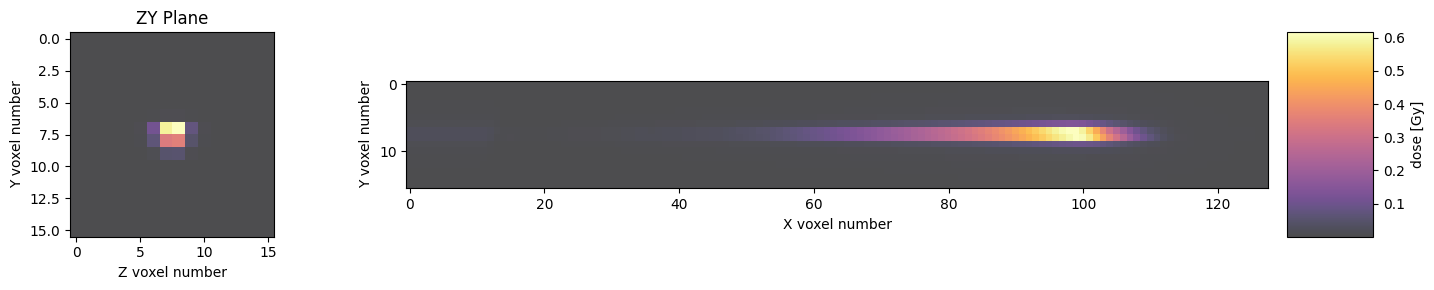

voxel number  10


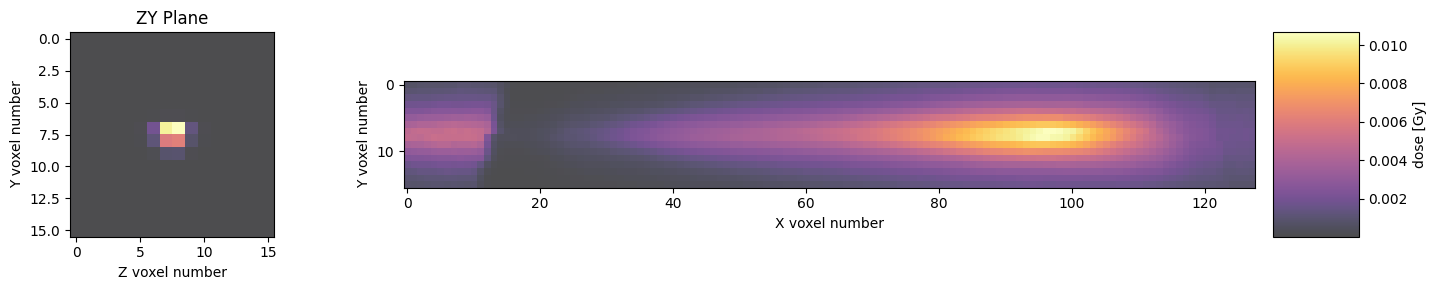

voxel number  11


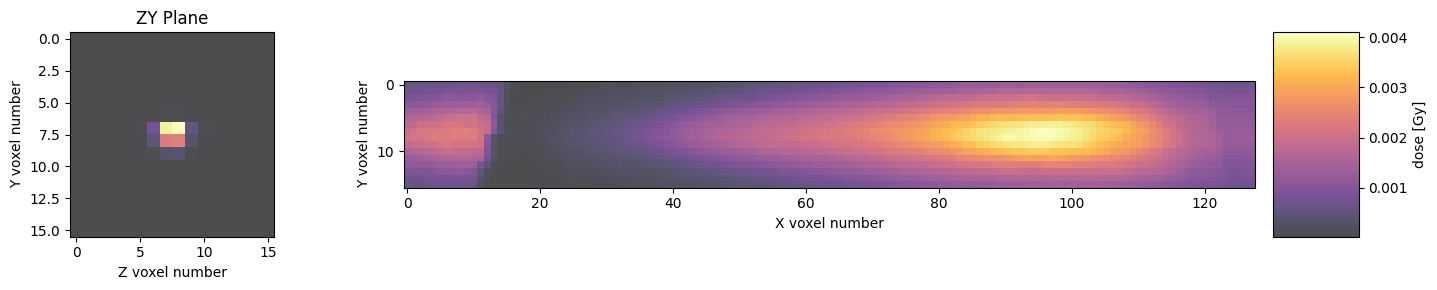

voxel number  12


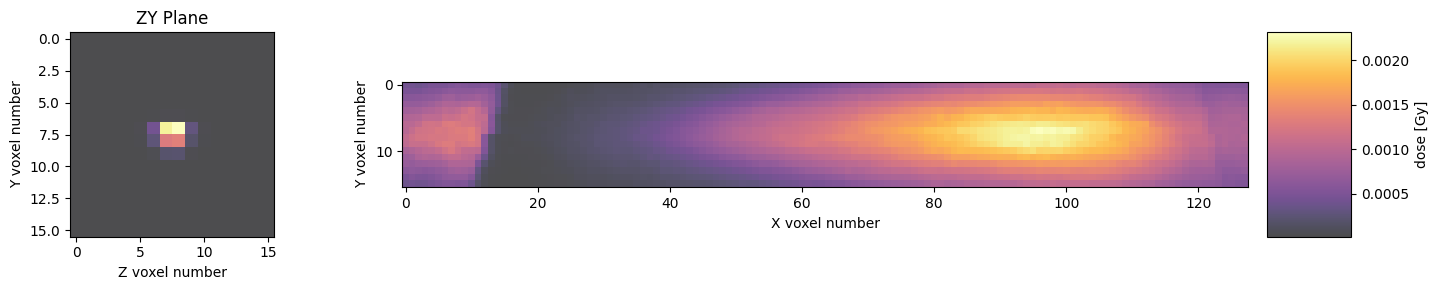

voxel number  13


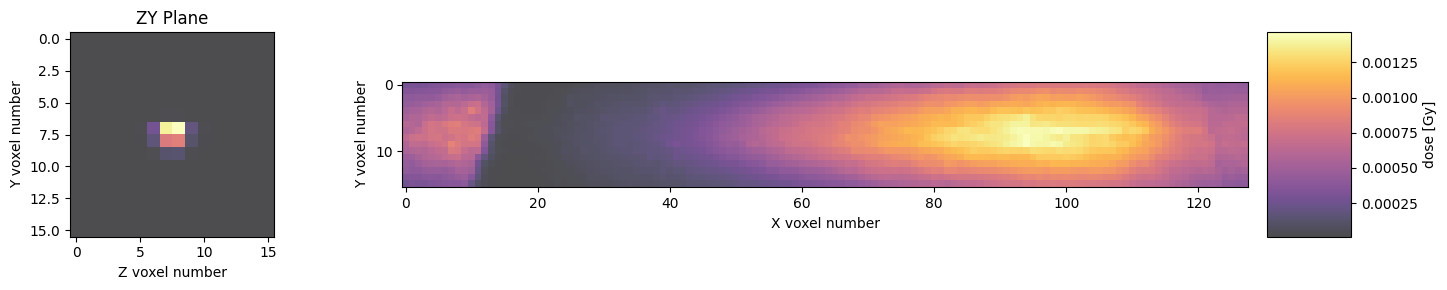

voxel number  14


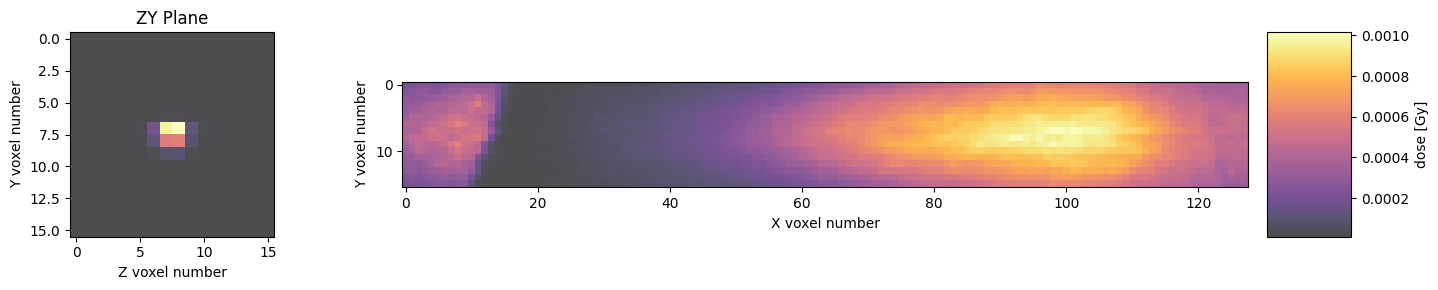

voxel number  15


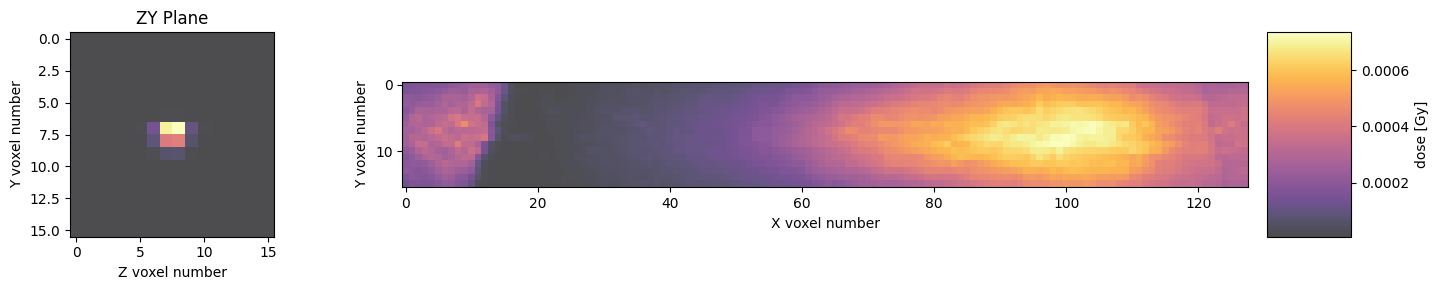

In [12]:
plot_roi(roi_array)

In [9]:
def get_original_shape(cropped_data, filename):
    # Initialize the original tensor with zeros
    original_data = np.zeros((126, 256, 256))

    y = to_voxel(extract_from_filename(filename, 'y'), 1)
    z = to_voxel(extract_from_filename(filename, 'z'), 0)
    # Calculate the starting points
    start_x = 60
    start_y = y - 8
    start_z = z - 8
    
    # Calculate the ending points
    end_x = start_x + 128
    end_y = start_y + 16
    end_z = start_z + 16
    print('Z range:', start_z, "-", end_z)
    print('Y range:', start_y, "-", end_y)
    print('X range:', start_x, "-", end_x)
    # Assign values directly using tensor indexing
    original_data[start_z:end_z, start_y:end_y, start_x:end_x] = cropped_data
    

    return original_data


def plot_brain(dose): #plot with shape zyx 126*256*256

    VOXELNUMBER_X = 256
    VOXELNUMBER_Y = 256
    VOXELNUMBER_Z = 126

    DELTA_Z = 2.5
    DELTA_X = 0.707031*2
    DELTA_Y = 0.707031*2

    x_vals = np.arange(-181, 181-DELTA_X, DELTA_X)
    x_vals = x_vals + DELTA_X/2

    y_vals = np.arange(-181, 181-DELTA_Y, DELTA_Y)
    y_vals = y_vals + DELTA_Y/2

    z_vals = np.arange(-229, 86, DELTA_Z) 
    z_vals =  z_vals + DELTA_Z/2

    max_index = np.unravel_index(dose.argmax(), dose.shape)


    dose_x = []
    dose_y = []
    dose_z = []
    for x in range(VOXELNUMBER_X):
        #dose_x.append(dose[int(max_index[0]), int(max_index[1]),x])
        dose_x.append(np.sum(dose[:, :, x]))        
    for y in range(VOXELNUMBER_Y):
        #dose_y.append(dose[int(max_index[0]),y,int(max_index[2])])
        dose_y.append(np.sum(dose[:, y, :]))   
    for z in range(VOXELNUMBER_Z):        
        #dose_z.append(dose[z, int(max_index[1]),int(max_index[2])])
        dose_z.append(np.sum(dose[z, :, :]))   

    # Create a 2x3 grid of subplots

    fig = plt.figure(figsize=(8, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[0.7, 0.7, 1])  # 3 plots
    ax2 = plt.subplot(gs[2])
    ax2.plot(x_vals, dose_x)
    ax2.set_yscale('linear')
    ax2.set_xlabel('X [mm] (Beam direction)')
    #ax2.set_ylabel('Dose [Gy]')

    #axs[2].set_title('Dose Distribution in water along X direction')

    ax1 = plt.subplot(gs[1])
    ax1.plot(y_vals, dose_y)
    ax1.set_yscale('linear')
    ax1.set_xlabel('Y [mm]')
    #ax1.set_ylabel('Dose [Gy]')
    #axs[1].set_title('Dose Distribution in water along Y direction')

    ax0 = plt.subplot(gs[0])
    ax0.plot(z_vals, dose_z)
    ax0.set_yscale('linear')
    ax0.set_xlabel('Z [mm]')
    ax0.set_ylabel('Dose [Gy]')
    ax0.set_title('Dose in head phantom at beam center : ('+ filename +')')
    #axs[0].set_title('Dose Distribution in water along Z direction')

    
    plt.tight_layout()
    plt.show()  

def to_voxel(position, axis):
    '''find voxel number as integer from position in mm. 
    Axis number representation 
    0 = z, 1 = y, 2 = x (beam)
    '''
    DELTA_Z = 2.5
    DELTA_X = 0.707031*2
    DELTA_Y = 0.707031*2
    if axis ==0:
        voxel = (position + 229) /DELTA_Z
    if axis ==1:
        voxel = (position + 181) /DELTA_Y
    if axis ==2:
        voxel = (position + 181) /DELTA_X
    return int(voxel) 


def extract_from_filename(filename, param):
    """Extracts energy value from the given filename."""
    parts = filename.split('_')
    if param == 'y':
        return float(parts[2][:-2])
    if param == 'z':
        return float(parts[3][:-6])
    if param == 'energy':
        return parts[1]
    else:
        return None

In [19]:
original_tensor = get_original_shape(roi_array, filename)
original_tensor.shape


Z range: 25 - 41
Y range: 120 - 136
X range: 60 - 188


(126, 256, 256)

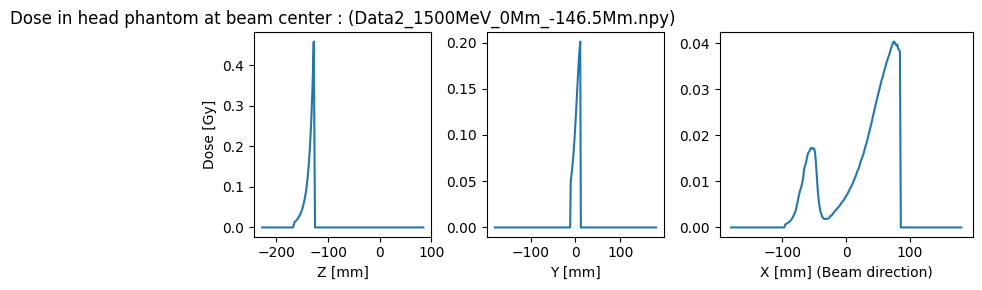

In [20]:
plot_brain(original_tensor)

In [1]:

# conversion function 
# take into account the placement of the voxel container volume 


def mm_to_voxel(position, voxel_dim, origin):
    # Subtracting the origin to get relative position
    relative_position = [position[i] - origin[i] for i in range(3)]
    
    # Convert mm position to voxel units using the voxel dimensions
    voxel_position = [int(round(relative_position[i] / voxel_dim[i])) for i in range(3)]
    
    return voxel_position


# Convert positions for each dataset
for dataset_name, dataset_info in datasets.items():
    for pos_x in dataset_info["positions_x"]:
        for pos_y in dataset_info["positions_y"]:
            for pos_z in dataset_info["positions_z"]:
                voxel_coords = mm_to_voxel([pos_x, pos_y, pos_z], dataset_info["voxel_dim"], dataset_info["origin"])
                print(f"Dataset: {dataset_name}, mm: ({pos_x}, {pos_y}, {pos_z}), Voxel: {voxel_coords}")


Dataset: Miriam, mm: (-110, -50, -146.5), Voxel: [-156, -71, -60]
Dataset: Miriam, mm: (-110, -50, -121.5), Voxel: [-156, -71, -40]
Dataset: Miriam, mm: (-110, -50, -96.5), Voxel: [-156, -71, -20]
Dataset: Miriam, mm: (-110, -50, -71.5), Voxel: [-156, -71, 0]
Dataset: Miriam, mm: (-110, -50, -46.5), Voxel: [-156, -71, 20]
Dataset: Miriam, mm: (-110, -25, -146.5), Voxel: [-156, -35, -60]
Dataset: Miriam, mm: (-110, -25, -121.5), Voxel: [-156, -35, -40]
Dataset: Miriam, mm: (-110, -25, -96.5), Voxel: [-156, -35, -20]
Dataset: Miriam, mm: (-110, -25, -71.5), Voxel: [-156, -35, 0]
Dataset: Miriam, mm: (-110, -25, -46.5), Voxel: [-156, -35, 20]
Dataset: Miriam, mm: (-110, 0, -146.5), Voxel: [-156, 0, -60]
Dataset: Miriam, mm: (-110, 0, -121.5), Voxel: [-156, 0, -40]
Dataset: Miriam, mm: (-110, 0, -96.5), Voxel: [-156, 0, -20]
Dataset: Miriam, mm: (-110, 0, -71.5), Voxel: [-156, 0, 0]
Dataset: Miriam, mm: (-110, 0, -46.5), Voxel: [-156, 0, 20]
Dataset: Miriam, mm: (-110, 25, -146.5), Voxel: 

resample_image: You need to specify the desired voxel spacing for the image.

adjust_fov: You'll set the voxel container volume placement for the dataset you're adjusting.

Cropping a dataset to focus on a specific region of interest (ROI) to reduce computational complexity. Once we have a consistent scale and FOV across datasets, we can reliably crop the same anatomical region in every dataset.

In [ ]:
# Ensure that center_xyz coordinates are given in voxel units, not physical units (mm). 
# need to convert them to voxel units using voxel dimensions.
def crop_roi(image, center_xyz, shape):
    start_x = center_xyz[0] - shape[0] // 2
    end_x = start_x + shape[0]
    
    start_y = center_xyz[1] - shape[1] // 2
    end_y = start_y + shape[1]
    
    start_z = center_xyz[2] - shape[2] // 2
    end_z = start_z + shape[2]
    
    return image[start_x:end_x, start_y:end_y, start_z:end_z]

# Example
center_xyz = [x, y, z]  # Adjust this to your known location
shape = [16, 16, 128]
cropped_image = crop_roi(adjusted_miriam, center_xyz, shape)
